1) Check out the Jupyter notebook for Chapter 8 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb. It uses the convolutional base of VGG16 for an image classification task, and also tries fine tuning. Your task: use another existing trained neural network (which is different from VGG16, such as ResNet) for the same task, and also try fine tuning. Submit your complete code, draw figures on the training/validation performance, and show the testing performance.

### Downloading the data

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import torch


In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shwetasharma75","key":"9e2368786efcf36eae200a631ffe6489"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:20<00:00, 44.7MB/s]
100% 812M/812M [00:20<00:00, 41.2MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,  exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the ResNet50 convolutional base**

In [ ]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

#### Fast feature extraction without data augmentation

**Extracting the ResNet50 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.resnet50.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 52ms/step


In [ ]:
train_features.shape

(2000, 6, 6, 2048)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(6, 6, 2048))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 4s 33ms/step - loss: 17.3440 - accuracy: 0.9220 - val_loss: 11.0079 - val_accuracy: 0.9360
Epoch 2/20
63/63 [==============================] - 2s 25ms/step - loss: 3.2120 - accuracy: 0.9815 - val_loss: 2.2295 - val_accuracy: 0.9800
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 1.0808 - accuracy: 0.9905 - val_loss: 4.5161 - val_accuracy: 0.9760
Epoch 4/20
63/63 [==============================] - 1s 15ms/step - loss: 0.5671 - accuracy: 0.9955 - val_loss: 3.7187 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 0.3319 - accuracy: 0.9970 - val_loss: 2.4764 - val_accuracy: 0.9800
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 0.8481 - accuracy: 0.9930 - val_loss: 2.4223 - val_accuracy: 0.9810
Epoch 7/20
63/63 [==============================] - 1s 13ms/step - loss: 0.5016 - accuracy: 0.9960 - val_loss: 2.9257 - val_accuracy: 0.9820
Epoch 8/20


**Plotting the results**

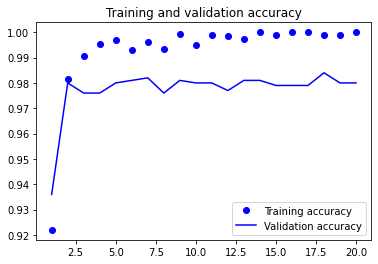

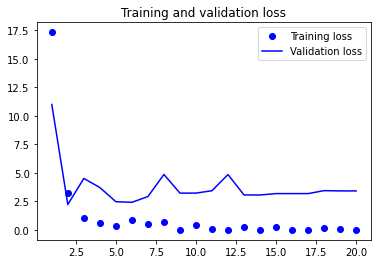

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the ResNet50 convolutional base**

In [ ]:
conv_base  = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 212


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 26s 297ms/step - loss: 17.4095 - accuracy: 0.9205 - val_loss: 5.4006 - val_accuracy: 0.9650
Epoch 2/50
63/63 [==============================] - 18s 285ms/step - loss: 6.7545 - accuracy: 0.9560 - val_loss: 6.4024 - val_accuracy: 0.9680
Epoch 3/50
63/63 [==============================] - 18s 287ms/step - loss: 4.1448 - accuracy: 0.9705 - val_loss: 4.2272 - val_accuracy: 0.9770
Epoch 4/50
63/63 [==============================] - 19s 297ms/step - loss: 4.0919 - accuracy: 0.9690 - val_loss: 2.9934 - val_accuracy: 0.9820
Epoch 5/50
63/63 [==============================] - 18s 286ms/step - loss: 5.1010 - accuracy: 0.9700 - val_loss: 5.9597 - val_accuracy: 0.9700
Epoch 6/50
63/63 [==============================] - 17s 270ms/step - loss: 2.7762 - accuracy: 0.9770 - val_loss: 3.8630 - val_accuracy: 0.9800
Epoch 7/50
63/63 [==============================] - 17s 271ms/step - loss: 2.0199 - accuracy: 0.9865 - val_loss: 3.7044 - val_accuracy: 0.9770
Epoch 8/5

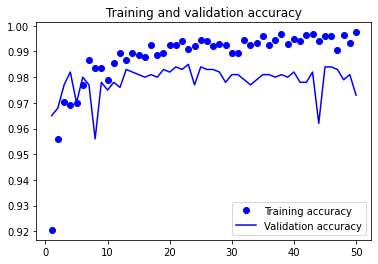

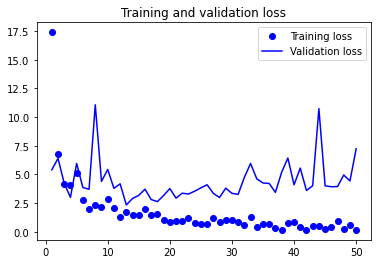

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 76ms/step - loss: 3.9105 - accuracy: 0.9790
Test accuracy: 0.979


### Fine-tuning a pretrained model

In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


63/63 [==============================] - 26s 294ms/step - loss: 6.4349 - accuracy: 0.9630 - val_loss: 5.2459 - val_accuracy: 0.9790
Epoch 2/30
63/63 [==============================] - 17s 274ms/step - loss: 2.6602 - accuracy: 0.9810 - val_loss: 4.5572 - val_accuracy: 0.9780
Epoch 3/30
63/63 [==============================] - 18s 290ms/step - loss: 2.6010 - accuracy: 0.9795 - val_loss: 4.0643 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 17s 273ms/step - loss: 2.2080 - accuracy: 0.9825 - val_loss: 3.8445 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 18s 283ms/step - loss: 2.9781 - accuracy: 0.9765 - val_loss: 3.5749 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 19s 292ms/step - loss: 1.4575 - accuracy: 0.9880 - val_loss: 3.4135 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 19s 287ms/step - loss: 1.9308 - accuracy: 0.9835 - val_loss: 3.4018 - val_accuracy: 0.9820
Epoch 8/30

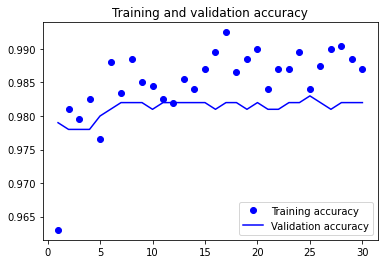

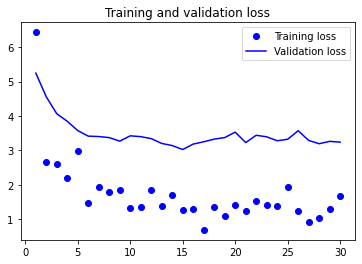

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 72ms/step - loss: 4.3075 - accuracy: 0.9770
Test accuracy: 0.977


Therefore, the test accuracy comes out to be around 97%.